In [116]:
import os
import pandas as pd
import torch

def load_resistor_data(data_dir):
    # 創建一個字典來保存所有電阻和電壓的數據
    data = {}
    
    # 遍歷每個電壓資料夾
    for voltage_folder in os.listdir(data_dir):
        voltage_path = os.path.join(data_dir, voltage_folder)
        if os.path.isdir(voltage_path):
            # 創建一個子字典來保存這個電壓下的所有電阻數據
            data[voltage_folder] = {}
            
            # 遍歷該電壓資料夾中的所有電阻文件
            for resistor_file in os.listdir(voltage_path):
                resistor_path = os.path.join(voltage_path, resistor_file)
                if resistor_file.endswith('.csv'):
                    # 讀取CSV文件到一個DataFrame中
                    resistor_data = pd.read_csv(resistor_path)
                    
                    # 將數據存入字典中
                    resistor_name = os.path.splitext(resistor_file)[0]  # 獲取文件名（去掉擴展名）
                    data[voltage_folder][resistor_name] = resistor_data
                    
    return data

# 假設數據位於 /data/ 目錄中
data_dir = 'C:\\Users\\walter\\OneDrive\\桌面\\收集\\2024大數據競賽\\2024-pre-train'
resistor_data = load_resistor_data(data_dir)

# 查看讀取的數據結構
for voltage, resistors in resistor_data.items():
    print(f"Voltage: {voltage}")
    for resistor, df in resistors.items():
        print(f"  Resistor: {resistor}, Data shape: {df.shape}")

#print(resistor_data['1']['a'])
import numpy as np

def split_data_for_training(resistor_data):
    train_inputs = []
    train_outputs = []
    
    # 遍歷每個電壓資料夾
    for voltage, resistors in resistor_data.items():
        for resistor, df in resistors.items():
            # 檢查數據是否有足夠的行數
            if len(df) >= 4000:
                # 前50筆數據作為輸入
                input_data = df.iloc[:3950].values  # 使用 .values 轉換為 numpy 數組
                # 後3950筆數據作為輸出
                output_data = df.iloc[3950:4000].values
                
                train_inputs.append(input_data)
                train_outputs.append(output_data)
    
    # 將結果轉換為 numpy 數組，方便後續使用
    train_inputs = np.array(train_inputs)
    train_outputs = np.array(train_outputs)
    
    return train_inputs, train_outputs

# 分割數據
train_inputs, train_outputs = split_data_for_training(resistor_data)

# 查看數據形狀
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Train outputs shape: {train_outputs.shape}")



Voltage: 1
  Resistor: a, Data shape: (4000, 11)
  Resistor: b, Data shape: (4000, 11)
  Resistor: c, Data shape: (4000, 11)
  Resistor: d, Data shape: (4000, 11)
Voltage: 10
  Resistor: a, Data shape: (4000, 11)
  Resistor: b, Data shape: (4000, 11)
  Resistor: c, Data shape: (4000, 11)
  Resistor: d, Data shape: (4000, 11)
Voltage: 11
  Resistor: a, Data shape: (4000, 11)
  Resistor: b, Data shape: (4000, 11)
  Resistor: c, Data shape: (4000, 11)
  Resistor: d, Data shape: (4000, 11)
Voltage: 12
  Resistor: a, Data shape: (4000, 11)
  Resistor: b, Data shape: (4000, 11)
  Resistor: c, Data shape: (4000, 11)
  Resistor: d, Data shape: (4000, 11)
Voltage: 13
  Resistor: a, Data shape: (4000, 11)
  Resistor: b, Data shape: (4000, 11)
  Resistor: c, Data shape: (4000, 11)
  Resistor: d, Data shape: (4000, 11)
Voltage: 2
  Resistor: a, Data shape: (4000, 11)
  Resistor: b, Data shape: (4000, 11)
  Resistor: c, Data shape: (4000, 11)
  Resistor: d, Data shape: (4000, 11)
Voltage: 3
  Resis

In [117]:

print(f"test target output: {resistor_data['13']['a'].iloc[:50, 1]}")



test target output: 0     442
1     440
2     436
3     432
4     429
5     425
6     421
7     417
8     414
9     411
10    408
11    404
12    401
13    397
14    394
15    391
16    388
17    385
18    381
19    378
20    375
21    372
22    369
23    366
24    363
25    360
26    357
27    354
28    351
29    348
30    345
31    342
32    339
33    337
34    334
35    331
36    328
37    326
38    324
39    321
40    319
41    316
42    314
43    311
44    309
45    307
46    304
47    302
48    300
49    297
Name: y01, dtype: int64


# 模型
##### 子模型1

In [118]:
import torch
import torch.nn as nn

class ResistancePredictor(nn.Module):
    def __init__(self):
        super(ResistancePredictor, self).__init__()
        # 全連接層，用於將輸入轉換為單一電阻值
        self.fc1 = nn.Linear(50*11 , 50)
        self.fc2=nn.Linear(50,1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x=self.dropout(x)
        x = torch.relu(self.fc1(x))
        x=self.dropout(x)
        resistance = (self.fc2(x))
        return resistance


##### 子模型2

In [119]:


class resmodel(nn.Module):
    def __init__(self,input_size):
        super(resmodel,self).__init__()
        print('input_size_1',input_size)

        self.l=nn.Linear(50+11,50)

        self.b=nn.Linear(50+1,50)
        self.dropout = nn.Dropout(p=0.2)


    def forward(self,x,id):
        #log=self.dropout(id)
        exp=self.l(id)
        exp =5*torch.sigmoid(exp) # 限制输出范围
        exp=torch.exp(exp)
        #print("exp",exp)
        #b=self.dropout(id)
        b=self.b(x)
        b=torch.relu(b)

        return exp+b



##### 合併

In [120]:
device = torch.device("cuda:0")

class CompleteModel(nn.Module):
    def __init__(self):
        super(CompleteModel, self).__init__()

        self.resistance_predictor = ResistancePredictor()
        self.timeLong = 50
        self.res = resmodel(input_size=25)
    
    def forward(self, bcd_input, target_input,id,j, mode='train',):
        if mode == 'train':
            resistance = self.resistance_predictor(bcd_input)

            # 确保输出张量初始化时在正确的设备上
            output = torch.empty(4000)

            for i in range(0,3950,25):

                temp = target_input[i:i+self.timeLong]
                #print('temp size',temp.size())
                # 将 resistance_predictor 拼接到 temp 中
                temp = torch.cat((temp, resistance), dim=-1)
                # 创建一个全为零的长度为 10 的一维张量
                one_hot_tensor = torch.zeros(10)

                # 将第 j-1 个位置的值设置为 1 (因为索引从 0 开始)
                one_hot_tensor[int(j) - 1] = 1

                temp_id=id[i:i+self.timeLong]
                temp_id = torch.cat((temp_id, resistance), dim=-1)
                temp_id = torch.cat((temp_id, one_hot_tensor.to(device)))

                #print('temp',temp.shape)
                # 通过 resmodel 模型预测
                res = self.res(temp,temp_id)
                res_temp=res[25:]
                # 将结果拼接到 data 中

                if i == 50:
                    output[i+self.timeLong:i+self.timeLong+25] = res[:25]

                elif i == 3975:
                    output[i+self.timeLong:i+self.timeLong+25] = res[25:]
                else:
                    output[i+self.timeLong:i+self.timeLong+25] = (res[:25]+res_temp)/2

            
            output = output.to(device)
            #print("output shape",output.shape)
            return output[50:]
        
        elif mode == 'test':
            resistance = self.resistance_predictor(bcd_input)
            
            for i in range(50, 4000, 25):
                temp = target_input[-self.timeLong:]
                temp = torch.cat((temp, resistance), dim=-1)
                one_hot_tensor = torch.zeros(10)


                # 将第 j-1 个位置的值设置为 1 (因为索引从 0 开始)
                one_hot_tensor[int(j) - 1] = 1

                temp_id=id[i-self.timeLong:i]
                temp_id = torch.cat((temp_id, resistance), dim=-1)
                temp_id = torch.cat((temp_id, one_hot_tensor.to(device)))


                res = self.res(temp,temp_id)
                res_temp=res[25:]
                if i == 50:
                    target_input = torch.cat((target_input, res[:25]), dim=0)
                elif i == 3975:
                    target_input = torch.cat((target_input, res[25:]), dim=0)
                else:
                    target_input = torch.cat((target_input, (res[:25] + res_temp) / 2), dim=0)
            #print("target_input shape",target_input.shape)

            return target_input[50:]

        '''
        for i in range(79):

            temp = target_input[-self.timeLong:]
            #print('temp size',temp.size())
            # 将 resistance_predictor 拼接到 temp 中
            
            # 通过 resmodel 模型预测
            res = self.res(temp)
            #print('temp',temp)
            # 将结果拼接到 data 中
            target_input = torch.cat((target_input, res), dim=0)
        return target_input[50:]
        '''

# 訓練

In [128]:
import torch.optim as optim
from torch.nn import init
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import time



type='a'
# 建立模型
model = CompleteModel()
device = torch.device("cuda:0")
torch.cuda.empty_cache()

# 初始化网络参数
for params in model.parameters():
    init.normal_(params, mean=0, std=0.01)

print(model)
# 定義損失函數和優化器
criterion = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr= 1.15E-07, momentum=0.9)

#optimizer = optim.Adam(model.parameters(), lr=0.1)       # 高动量

# 假設有訓練數據 train_bcd_input, train_target_input, train_target_output

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.9, verbose=True)

num_epochs=750
# 使用一個簡單的訓練迴圈
all_train_loss=[]
all_test_loss=[]
model=model.to(device)

for epoch in range(num_epochs):  # 假設訓練100個epoch
    start=time.time()

    model.train()
    trl=[]
    for voltage in range(1, 13):     
        voltage = str(voltage)  # 將數字轉換為字串
    
        input_1=resistor_data[voltage][type].iloc[:50].to_numpy().flatten()
        input_1=torch.from_numpy(input_1).float()
        input_1 = input_1.to(device)

        id=resistor_data[voltage][type].iloc[:,0].to_numpy()
        id=torch.from_numpy(id).float()
        id = id.to(device)

        for j in range(1,11):
            
            input_2=resistor_data[voltage][type].iloc[:,j].to_numpy()
            input_2=torch.from_numpy(input_2).float()
            input_2 = input_2.to(device)

            target_out=resistor_data[voltage][type].iloc[50:,j].to_numpy()
            target_out=torch.from_numpy(target_out).float()
            target_out = target_out.to(device)


            optimizer.zero_grad()
            
            # 前向傳播
            outputs = model(input_1, input_2,id,mode='train',j=j)
            # 計算損失
            # 调试输出形状
            #print(f"Epoch {epoch}, Voltage {voltage}, Iter {j}")
            #print(f"outputs shape: {outputs.shape}, target_out shape: {target_out.shape}")

            # 确保形状匹配
            if outputs.shape != target_out.shape:
                raise ValueError(f"Shape mismatch: outputs shape {outputs.shape}, target_out shape {target_out.shape}")

            # 计算损失
            loss = torch.sqrt(criterion(outputs, target_out))

            # 调试输出 `grad_fn`
            #print(f"outputs grad_fn: {outputs.grad_fn}")



            # 反向傳播和優化
            loss.backward()

            # 限制权重的大小，使用max-norm正则化
            for param in model.parameters():
                nn.utils.clip_grad_norm_(param, max_norm=5.0)
        

            optimizer.step()
            trl.append(loss.item())

            
    all_train_loss.append(np.mean(trl))
    scheduler.step(np.mean(trl))

    #test
    model.eval()

    tel=[]
    test_input_1=resistor_data['13'][type].iloc[:50].to_numpy().flatten()
    test_input_1=torch.from_numpy(test_input_1).float()
    test_input_1 = test_input_1.to(device)

    test_id=resistor_data['13'][type].iloc[:,0].to_numpy()
    test_id=torch.from_numpy(test_id).float()
    test_id = test_id.to(device)

    for j in range(1,11):
        test_input_2=resistor_data['13'][type].iloc[:50,j].to_numpy()
        test_input_2=torch.from_numpy(test_input_2).float()
        test_input_2 = test_input_2.to(device)


        test_output=model(test_input_1,test_input_2,id=test_id,mode='test',j=j)
        
        test_target_out=resistor_data['13'][type].iloc[50:,j].to_numpy()
        test_target_out=torch.from_numpy(test_target_out).float()
        test_target_out = test_target_out.to(device)


        test_loss = torch.sqrt(criterion(test_output, test_target_out))
        tel.append(test_loss.item())
    all_test_loss.append(np.mean(tel))

    
    
    print(f'Epoch {epoch}, Loss: {np.mean(trl)},test loss: {np.mean(tel)}')
    print('time',time.time()-start,'sec','net par')

#print("all_train_loss",all_train_loss)
x=np.linspace(start=0,stop=num_epochs,num=len(all_train_loss))
#print("x",x)

plt.plot(x,all_train_loss, 'r:')
plt.plot(x,all_test_loss, 'b:')
plt.legend(['train loss','test loss'])

plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')          # log y-axis

plt.show()  

    
print('outputs',outputs)
torch.cuda.empty_cache()


'''
timeLong=50
for epoch in range(10000):
    all_outputs=train_target_input
    temp = train_target_input[-timeLong:]

    for i in range(3950):
        temp = temp[-timeLong:]
        optimizer.zero_grad()

        #print('temp size',temp.size())
        # 前向傳播
        outputs = model(temp)
        
        # 計算損失
        #print('outputs',outputs.size())
        #print('train_target_output[i]',train_target_output[i].size())
        train_target_output_num = torch.tensor([train_target_output[i].item()])

        loss = torch.sqrt(criterion(outputs, train_target_output_num))
        
        # 反向傳播和優化
        loss.backward()
        optimizer.step()
        temp = torch.cat((temp, outputs), dim=0)
        all_outputs = torch.cat((all_outputs, outputs), dim=0)


    # 計算損失
    #print('all_outputs size',all_outputs[50:].size())
    #print("train_target_output",train_target_output.size())
    all_loss = torch.sqrt(criterion(all_outputs[50:], train_target_output))
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, all_Loss: {all_loss.item()}')

print('outputs',all_outputs[50:])
'''


input_size_1 25
CompleteModel(
  (resistance_predictor): ResistancePredictor(
    (fc1): Linear(in_features=550, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=1, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (res): resmodel(
    (l): Linear(in_features=61, out_features=50, bias=True)
    (b): Linear(in_features=51, out_features=50, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)
Epoch 0, Loss: 183.03879108428956,test loss: 63.50257339477539
time 17.144586324691772 sec net par
Epoch 1, Loss: 181.105672899882,test loss: 63.38045883178711
time 16.46148681640625 sec net par
Epoch 2, Loss: 180.6038617769877,test loss: 63.25849380493164
time 16.232955932617188 sec net par
Epoch 3, Loss: 180.30575354894003,test loss: 63.15822792053223
time 16.658860445022583 sec net par


KeyboardInterrupt: 

input_size_1 25
CompleteModel(
  (resistance_predictor): ResistancePredictor(
    (fc1): Linear(in_features=550, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=1, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (res): resmodel(
    (l): Linear(in_features=61, out_features=50, bias=True)
    (b): Linear(in_features=51, out_features=50, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.18E-07


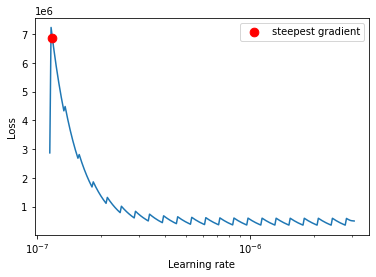

In [127]:


import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import init
from torch_lr_finder import LRFinder


class ResistorDataset(Dataset):
    def __init__(self, resistor_data, voltages, type):
        self.resistor_data = resistor_data
        self.voltages = voltages
        self.type = type

    def __len__(self):
        return len(self.voltages) * 11  # 每个电压有11个input_2

    def __getitem__(self, idx):
        voltage_idx = idx // 11  # 计算电压索引
        j = idx % 11  # 计算 j 索引

        voltage = str(self.voltages[voltage_idx])
        input_1 = self.resistor_data[voltage][self.type].iloc[:50].to_numpy().flatten()
        input_2 = self.resistor_data[voltage][self.type].iloc[:, j].to_numpy()
        target = self.resistor_data[voltage][self.type].iloc[50:, j].to_numpy()

        input_1 = torch.from_numpy(input_1).float()
        input_2 = torch.from_numpy(input_2).float()
        target = torch.from_numpy(target).float()

        id=resistor_data[voltage][type].iloc[:,0].to_numpy()
        id=torch.from_numpy(id).float()
        id = id.to(device)

        #print("input_2",input_2)
        return input_1, input_2,id,j,target


from torch_lr_finder import LRFinder

class CustomLRFinder(LRFinder):
    def _move_to_device(self, tensor, non_blocking=True):
        return tensor.to(self.device, non_blocking=non_blocking)
    
    def _train_batch(self, train_iter, accumulation_steps, non_blocking_transfer=True):
        self.model.train()
        total_loss = None

        self.optimizer.zero_grad()

        for i in range(accumulation_steps):
            try:
                inputs, target_input = next(train_iter)
            except StopIteration:
                return -1

            # 解包 inputs
            inputs1, inputs2,id,j = inputs
           
            inputs1=inputs1.view(-1)
            inputs2=inputs2.view(-1)
            j=j.view(-1)
            #print("j",j)
            id=id.view(-1)
            target_input=target_input.view(-1)
            #print("inputs1 s",inputs1.shape)
            #print("inputs2 s",inputs2.shape)
            # 移動數據到設備上
            inputs1 = self._move_to_device(inputs1, non_blocking=non_blocking_transfer)
            inputs2 = self._move_to_device(inputs2, non_blocking=non_blocking_transfer)
            target_input = self._move_to_device(target_input, non_blocking=non_blocking_transfer)

            # 前向傳播
            outputs = self.model(inputs1, inputs2,id,mode='train',j=j)
            loss = self.criterion(outputs, target_input)

            # 平均損失
            loss /= accumulation_steps

            # 反向傳播
            loss.backward()

            if total_loss is None:
                total_loss = loss.detach().item()
            else:
                total_loss += loss.detach().item()

        self.optimizer.step()

        return total_loss




       



# Initialize and wrap the model
model = CompleteModel()

# Define voltages and create dataset and dataloaders
voltages = list(range(1, 14))  # 从1到13的电压值
type = 'a'

train_dataset = ResistorDataset(resistor_data, voltages=voltages[:-1], type=type)  # 使用1-12的电压作为训练集
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
'''
for input_1, input_2,t in train_loader:
    print("input_1",input_1)
    print("input_2",input_2)
    print("t",t)
'''
test_dataset = ResistorDataset(resistor_data, voltages=[13], type=type)  # 使用13的电压作为测试集
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize model parameters
device = torch.device("cuda:0")
print(model)
for params in model.parameters():
    #print(params)
    init.normal_(params, mean=0, std=0.01)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Use torch-lr-finder to find optimal learning rate
# 使用自定義的 LRFinder
class DataLoaderWrapper(torch.utils.data.DataLoader):
    def __iter__(self):
        for idx, batch in enumerate(super().__iter__()):
            # 構建符合 (inputs, targets) 結構的批次數據
            inputs = (batch[0], batch[1], batch[2], batch[3])
            targets = batch[4]
            
            #print(f"DataLoaderWrapper output - Index: {idx}, Inputs Length: {len(inputs)}, Targets Shape: {targets.shape}")
            
            yield inputs, targets

lr_finder = CustomLRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(DataLoaderWrapper(test_dataset),start_lr=1e-7, end_lr=1e-1, num_iter=1000, smooth_f=0.05,diverge_th=100)
#lr_finder.range_test(test_loader, end_lr=1, num_iter=100)
lr_finder.plot()  # 显示损失函数与学习率的关系图
lr_finder.reset()  # 重置模型和优化器到初始状态
